In [ ]:
from notebooks import *
print_sys_info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic
platform:
  machine: x86_64
  node: Dan-B.local
  processor: i386
  release: 15.6.0
  system: Darwin
  version: 'Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64'
cpu: 8
mem: 16g
swap: 17g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[02:13:04.042] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(recs=len(df), sp=df.species.nunique())
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (recs/sp)' % (desc, '%(recs)s/%(sp)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[35k/334 -> 25k/127 -> 21k/100 ->  10k/100 ->  10k/100]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[35k/334 -> 32k/224 -> 16k/100 -> 9.0k/100 -> 9.0k/100]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[35k/334 -> 35k/334 -> 12k/100 -> 6.8k/100 -> 6.8k/ 99]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[34k/334 -> 34k/334 -> 18k/168 ->  11k/168 ->  11k/167]  # compare.ipynb all
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[34k/334 -> 35k/334 -> 18k/168 ->  3.2/168 ->  3.2/167]  # compare.ipynb recs
# recs_at_least, num_species, num_recs =  20, 168,  20  # ca[35k/334 -> 35k/296 -> 20k/168 ->  3.4/168 ->  3.4/168]  # compare.ipynb recs
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  50   # Faster dev
recs_at_least, num_species, num_recs =  20, 50,  20   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  10   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  5    # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              399859/9442 (recs/sp)
countries         59713/1148 (recs/sp)
com_names          35236/334 (recs/sp)
(downloaded)       35232/334 (recs/sp)
recs_at_least      34846/296 (recs/sp)
num_species          5734/50 (recs/sp)


num_recs             1000/50 (recs/sp)
recs ≥ 2             1000/50 (recs/sp)


'recs[1000], sp[50]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,28000,1000,1000,1,NaN,NaN,True,True,True,True,True
species,category,53000,1000,1000,50,NaN,NaN,BFAL,GHOW,NRWS,NAWA,CAFI
id,int64,28000,1000,1000,1000,213619.749,109037.540,1151,135943,193155,312897,416059
sci_name,category,67640,1000,1000,50,NaN,NaN,Phoebastria nigripes,Bubo virginianus,Stelgidopteryx serripennis,Leiothlypis ruficapilla,Haemorhous cassinii
com_name,category,65900,1000,1000,50,NaN,NaN,Black-footed Albatross,Great Horned Owl,Northern Rough-winged Swallow,Nashville Warbler,Cassin's Finch
subspecies,object,50387,1000,1000,60,NaN,NaN,,,,,zaboria
recordist,object,63057,1000,1000,166,NaN,NaN,Aidan Place,Frank Lambert,Mike Nelson,Richard E Webster,markbird
country,object,60467,1000,1000,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,93293,1000,1000,640,NaN,NaN,Sand Island Midway Atoll,"Dana Point Harbor, Orange County, California","Mesa Trail, Boulder County, Colorado","Saint Gabriel, Iberville Par., LA","west of Thorp, WA"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
LEBI,266564,True,LEBI,143606,Ixobrychus exilis,Least Bittern,,Paul Marvin,United States,"Vendel Road, Salton Sea NWR, Brawley, Imperial County, California",33.1,-116.0,call,B,2013-03-13 00:00:00,12:31,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/143606,//www.xeno-canto.org/143606/download
BANO,60162,True,BANO,356413,Tyto alba,Western Barn Owl,,Paul Marvin,United States,"Dixie Way, Scottsmoor area, Brevard County, Florida",28.8,-80.9,call,B,2017-02-20 00:00:00,06:03,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/356413,//www.xeno-canto.org/356413/download
WTSW,54139,True,WTSW,362534,Aeronautes saxatalis,White-throated Swift,saxatalis,Frank Lambert,United States,"Colorado National Monument, Mesa County, Colorado",39.1,-109.0,flight call,A,2015-04-23 00:00:00,10:59,by-nc-nd,4.0,//creativecommons.org/licenses/by-nc-nd/4.0/,https://www.xeno-canto.org/362534,//www.xeno-canto.org/362534/download
BCHU,295164,True,BCHU,113485,Archilochus alexandri,Black-chinned Hummingbird,,Dan Lane,United States,"SW Patagonia, Arizona",31.5,-111.0,"call, chase calls",A,2012-08-25 00:00:00,16:00,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/113485,//www.xeno-canto.org/113485/download
CACW,91925,True,CACW,324044,Campylorhynchus brunneicapillus,Cactus Wren,couesi,Richard E. Webster,United States,"Portal, Arizona",31.9,-109.0,song,A,2015-04-23 00:00:00,08:05,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/324044,//www.xeno-canto.org/324044/download
PHAI,65435,True,PHAI,351072,Phainopepla nitens,Phainopepla,,Lance A. M. Benner,United States,"Sunset Peak lower saddle, Los Angeles County, California",34.2,-118.0,"call, male",B,2017-01-16 00:00:00,11:48,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/351072,//www.xeno-canto.org/351072/download
NOWA,4059,True,NOWA,413630,Parkesia noveboracensis,Northern Waterthrush,,Kellie,Canada,"Waterloo, Waterloo Regional Municipality, Ontario",43.5,-80.5,song,C,2014-05-29 00:00:00,06:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/413630,//www.xeno-canto.org/413630/download
WTSP,180499,True,WTSP,232949,Zonotrichia albicollis,White-throated Sparrow,,Paul Marvin,United States,"Park Point area, Duluth, Minnesota",46.7,-92.0,"""pink"", ""seet"", and laughing calls, song",C,2014-10-13 00:00:00,08:25,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/232949,//www.xeno-canto.org/232949/download
PUFI,251507,True,PUFI,159067,Haemorhous purpureus,Purple Finch,,Ian Cruickshank,Canada,"Pedder Bay, Metchosin, Vancouver Island, BC",48.4,-124.0,fledgling calls,C,2012-07-25 00:00:00,09:18,by-nc-nd,3.0,//creativecommons.org/licenses/by-nc-nd/3.0/,https://www.xeno-canto.org/159067,//www.xeno-canto.org/159067/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    # xcs_paths[:2],
)

1000

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,51000,1000,1000,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,53000,1000,1000,50,NaN,NaN,BFAL,GHOW,NRWS,NAWA,CAFI
species_com_name,category,65560,1000,1000,50,NaN,NaN,Black-footed Albatross,Great Horned Owl,Northern Rough-winged Swallow,Nashville Warbler,Cassin's Finch
species_query,object,53000,1000,1000,50,NaN,NaN,AMDI,CASP,LEBI,RCKI,YBCH
duration_s,float64,24000,1000,1000,971,5.338e+01,6.827e+01,0.697,13.6,29.7,63.7,650
samples_mb,float64,24000,1000,1000,971,2.245e+00,2.871e+00,0.0293,0.572,1.25,2.68,27.4
samples_n,int64,28000,1000,1000,971,1.177e+06,1.505e+06,15368,300096,654336,1405555,14341888
basename,object,54000,1000,1000,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,72560,1000,1000,50,NaN,NaN,Black-footed Albatross - BFAL,Great Horned Owl - GHOW,Northern Rough-winged Swallow - NRWS,Nashville Warbler - NAWA,Cassin's Finch - CAFI


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,BFAL,Black-footed Albatross,BFAL,210.0,8.83,4631616,audio,Black-footed Albatross - BFAL,xc/data/BFAL/116357/audio,xc/data/BFAL/116357/audio.mp3
1,xc,BFAL,Black-footed Albatross,BFAL,64.4,2.71,1419633,audio,Black-footed Albatross - BFAL,xc/data/BFAL/286476/audio,xc/data/BFAL/286476/audio.mp3
2,xc,BFAL,Black-footed Albatross,BFAL,250.0,10.50,5515873,audio,Black-footed Albatross - BFAL,xc/data/BFAL/166057/audio,xc/data/BFAL/166057/audio.mp3
3,xc,BFAL,Black-footed Albatross,BFAL,244.0,10.30,5378112,audio,Black-footed Albatross - BFAL,xc/data/BFAL/120995/audio,xc/data/BFAL/120995/audio.mp3
4,xc,BFAL,Black-footed Albatross,BFAL,64.3,2.71,1418278,audio,Black-footed Albatross - BFAL,xc/data/BFAL/165997/audio,xc/data/BFAL/165997/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plot below (7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Black-footed Albatross - BFAL,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
1,Least Bittern - LEBI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2,Great Egret - GREG,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3,Swainson's Hawk - SWHA,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4,Black Oystercatcher - BLOY,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
5,Long-billed Curlew - LBCU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Rock Sandpiper - ROSA,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Least Sandpiper - LESA,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Greater Yellowlegs - GRYE,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Western Gull - WEGU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = [
    dict(
        classifier=[

            # RandomForest(entropy)
            #   - [SP14] uses entropy
            # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 1000',
            # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 800',
            # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',
            # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # [SP14]
            # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
            # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
            # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',

            # RandomForest(gini)
            #   - sk uses gini by default

            # lightgbm
            'cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1',
            'cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .1,  min_child_samples: 1',
            'cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1.,  min_child_samples: 1',
            'cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .01, min_child_samples: 1',
            'cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .1,  min_child_samples: 1',
            'cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: 1.,  min_child_samples: 1',
            'cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .01, min_child_samples: 1',
            'cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .1,  min_child_samples: 1',
            'cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: 1.,  min_child_samples: 1',

            # WARNING These two are not very mem safe...
            #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
            # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 2000',
            # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1500',

            # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1000',
            # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 800',
            # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 600',
            # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
            'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
            'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
            'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
            # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # [sk default]
            # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1',  # Faster dev

        ],
        subset_species=[subset_species],
        subset_recs=[subset_recs],
    )
    for (subset_species, subset_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast
        (None, None),
        # (1.00, 1.00),
        # (1.00, 0.25),
        # (0.25, 1.00),
        # (0.25, 0.25),
    ]
]

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        # n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        n_splits=2,
        # n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        test_i='i_test',
        test_y='y_test',
        test_classes='estimator.classes_',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
    ),
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    n_jobs=1,  # For %prun
    # n_jobs=6,  # Doesn't peg all 8 hyperthreads
    # n_jobs=8,
    # n_jobs=16,  # Not mem safe on laptop (16x rf classifiers)
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[02:14:55.507] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1', random_state=0)]


[02:21:24.361] INFO   _fit_and_score[388.854s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1', random_state=0)]
[02:21:24.409] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1', random_state=0)]


[02:27:38.776] INFO   _fit_and_score[374.367s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1', random_state=0)]
[02:27:38.825] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .1,  min_child_samples: 1', random_state=0)]


[02:33:48.706] INFO   _fit_and_score[369.882s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .1,  min_child_samples: 1', random_state=0)]
[02:33:48.768] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .1,  min_child_samples: 1', random_state=0)]


[02:39:55.993] INFO   _fit_and_score[367.225s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .1,  min_child_samples: 1', random_state=0)]
[02:39:56.034] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1.,  min_child_samples: 1', random_state=0)]


[02:40:07.630] INFO   _fit_and_score[11.596s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1.,  min_child_samples: 1', random_state=0)]
[02:40:07.643] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1.,  min_child_samples: 1', random_state=0)]


[02:40:20.650] INFO   _fit_and_score[13.008s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1.,  min_child_samples: 1', random_state=0)]
[02:40:20.661] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .01, min_child_samples: 1', random_state=0)]


[02:43:34.768] INFO   _fit_and_score[194.107s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .01, min_child_samples: 1', random_state=0)]
[02:43:34.797] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .01, min_child_samples: 1', random_state=0)]


[02:47:17.784] INFO   _fit_and_score[222.987s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .01, min_child_samples: 1', random_state=0)]
[02:47:17.803] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .1,  min_child_samples: 1', random_state=0)]


[02:50:39.739] INFO   _fit_and_score[201.935s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .1,  min_child_samples: 1', random_state=0)]
[02:50:39.765] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .1,  min_child_samples: 1', random_state=0)]


[02:53:58.731] INFO   _fit_and_score[198.966s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: .1,  min_child_samples: 1', random_state=0)]
[02:53:58.757] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: 1.,  min_child_samples: 1', random_state=0)]


[02:54:05.737] INFO   _fit_and_score[6.979s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: 1.,  min_child_samples: 1', random_state=0)]
[02:54:05.743] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: 1.,  min_child_samples: 1', random_state=0)]


[02:54:12.810] INFO   _fit_and_score[7.067s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: 1.,  min_child_samples: 1', random_state=0)]
[02:54:12.817] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .01, min_child_samples: 1', random_state=0)]


[02:54:48.556] INFO   _fit_and_score[35.739s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .01, min_child_samples: 1', random_state=0)]
[02:54:48.566] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .01, min_child_samples: 1', random_state=0)]


[02:55:28.179] INFO   _fit_and_score[39.612s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .01, min_child_samples: 1', random_state=0)]
[02:55:28.189] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .1,  min_child_samples: 1', random_state=0)]


[02:56:13.072] INFO   _fit_and_score[44.883s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .1,  min_child_samples: 1', random_state=0)]
[02:56:13.081] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .1,  min_child_samples: 1', random_state=0)]


[02:56:52.935] INFO   _fit_and_score[39.853s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .1,  min_child_samples: 1', random_state=0)]
[02:56:52.945] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: 1.,  min_child_samples: 1', random_state=0)]


[02:56:57.761] INFO   _fit_and_score[4.816s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: 1.,  min_child_samples: 1', random_state=0)]
[02:56:57.770] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: 1.,  min_child_samples: 1', random_state=0)]


[02:57:02.795] INFO   _fit_and_score[5.025s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: 1.,  min_child_samples: 1', random_state=0)]
[02:57:02.804] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 200', random_state=0)]


[02:57:11.379] INFO   _fit_and_score[8.575s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 200', random_state=0)]
[02:57:11.421] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 200', random_state=0)]


[02:57:20.415] INFO   _fit_and_score[8.994s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 200', random_state=0)]
[02:57:20.473] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 100', random_state=0)]


[02:57:25.019] INFO   _fit_and_score[4.546s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 100', random_state=0)]
[02:57:25.044] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 100', random_state=0)]


[02:57:29.588] INFO   _fit_and_score[4.544s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 100', random_state=0)]
[02:57:29.609] INFO   _fit_and_score... split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 50', random_state=0)]


[02:57:31.957] INFO   _fit_and_score[2.347s]: split_i[0], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 50', random_state=0)]
[02:57:31.970] INFO   _fit_and_score... split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 50', random_state=0)]


[02:57:34.424] INFO   _fit_and_score[2.454s]: split_i[1], train[800], test[200], classes[50], estimator[Search(subset_species=None, subset_recs=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 50', random_state=0)]


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 42.6min finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, classifier_type, fold, ...
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: {
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_')},
        'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    }))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params
    .assign(
        # Useful for validation curves (vary params by classifier type)
        # classifier_type=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
        #     '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
        #     x['cls']
        # )),
        # Useful for learning curves (vary subset_* per classifier)
        classifier_type=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, v) for k, v in d.items() if not k.startswith('subset_')
        )),
        subsets=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, v) for k, v in d.items() if k.startswith('subset_')
        )),
    )
    # .eval
    .assign(
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df.pop('test_classes'),
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_subset_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        # TODO TODO
        test_score=lambda df: df.test_evals.map(lambda evals: evals.score()),
        # train_score=lambda df: df.train_evals.map(lambda evals: evals.score()),  # TODO Add train_evals above [investigate how]
        # TODO Add assert that new test_score == old test_score except where old test_score is -np.inf
        # FIXME train_score has some -np.inf's until we add train_evals (which might be nontrivial)
    )
    # Reorder
    .pipe(df_reorder_cols, first=[
        'model_id', 'params', 'params_dict', 'classifier_type', 'subsets',
        # 'train_score', 'test_score', 'test_score_TODO',  # XXX After adding new recomputed versions of test_score/train_score
    ])
)
param_list = list(reversed(cv_models.params.unique()))  # Reverse so they're roughly least to most complex
display(
    df_summary(cv_models).T,
    # cv_models[:5],
    cv_models,
    param_list,
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,4588,24,24,24.0,NaN,NaN,"classifier[cls: lgbm, random_state: 0, n_estimators: 10, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 10, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: lgbm, random_state: 0, n_estimators: 50, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 50], subset_recs[None], subset_species[None], fold[1]"
params,object,4372,24,24,12.0,NaN,NaN,"classifier[cls: lgbm, random_state: 0, n_estimators: 10, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 10, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 50, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 50], subset_recs[None], subset_species[None]"
params_dict,object,5760,24,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
classifier_type,object,3718,24,24,12.0,NaN,NaN,"classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 10, 'learning_rate': 0.01, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 10, 'learning_rate': 1.0, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 1.0, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 50, 'learning_rate': 1.0, 'min_child_samples': 1}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 50}]"
subsets,object,2112,24,24,1.0,NaN,NaN,"subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]"
fold,int64,624,24,24,2.0,NaN,NaN,0,0,0,1,1
train_score,float64,576,24,24,1.0,NaN,NaN,-1,-1,-1,-1,-1
test_score,float64,576,24,24,12.0,NaN,NaN,-44.5,-23,-7,-4,-2
fit_time,float64,576,24,24,24.0,NaN,NaN,2.01,4.57,12.5,198,388


,model_id,params,params_dict,classifier_type,subsets,fold,train_score,test_score,fit_time,score_time,test_evals
0,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","{'classifier': {'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}, 'subset_recs': None, 'subset_species': None}","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,-1.0,-6.0,388.00,0.133,"SearchEvals(i[(200,)], y[(200,)], classes[(50,)], y_scores[(200, 50)])"
1,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","{'classifier': {'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}, 'subset_recs': None, 'subset_species': None}","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",1,-1.0,-5.0,374.00,0.128,"SearchEvals(i[(200,)], y[(200,)], classes[(50,)], y_scores[(200, 50)])"
2,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .1, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .1, min_child_samples: 1], subset_recs[None], subset_species[None]","{'classifier': {'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.1, 'min_child_samples': 1}, 'subset_recs': None, 'subset_species': None}","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.1, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,-1.0,-4.0,369.00,0.155,"SearchEvals(i[(200,)], y[(200,)], classes[(50,)], y_scores[(200, 50)])"
3,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .1, min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .1, min_child_samples: 1], subset_recs[None], subset_species[None]","{'classifier': {'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.1, 'min_child_samples': 1}, 'subset_recs': None, 'subset_species': None}","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.1, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",1,-1.0,-4.0,367.00,0.147,"SearchEvals(i[(200,)], y[(200,)], classes[(50,)], y_scores[(200, 50)])"
4,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None]","{'classifier': {'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 1.0, 'min_child_samples': 1}, 'subset_recs': None, 'subset_species': None}","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 1.0, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,-1.0,-23.0,11.10,0.137,"SearchEvals(i[(200,)], y[(200,)], classes[(50,)], y_scores[(200, 50)])"
5,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None]","{'cl

[
  'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 50], subset_recs[None], subset_species[None]',
  'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 100], subset_recs[None], subset_species[None]',
  'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 200], subset_recs[None], subset_species[None]',
  'classifier[cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: 1.,  min_child_samples: 1], '
    'subset_recs[None], subset_species[None]',
  'classifier[cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .1,  min_child_samples: 1], '
    'subset_recs[None], subset_species[None]',
  'classifier[cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .01, min_child_samples: 1], '
    'subset_recs[None], subset_species[None]',
  'classifier[cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: 1.,  min_child_samples: 1], '
    'subset_recs[None], subset_species[None]',
  'classifier[cls: lgbm, rando

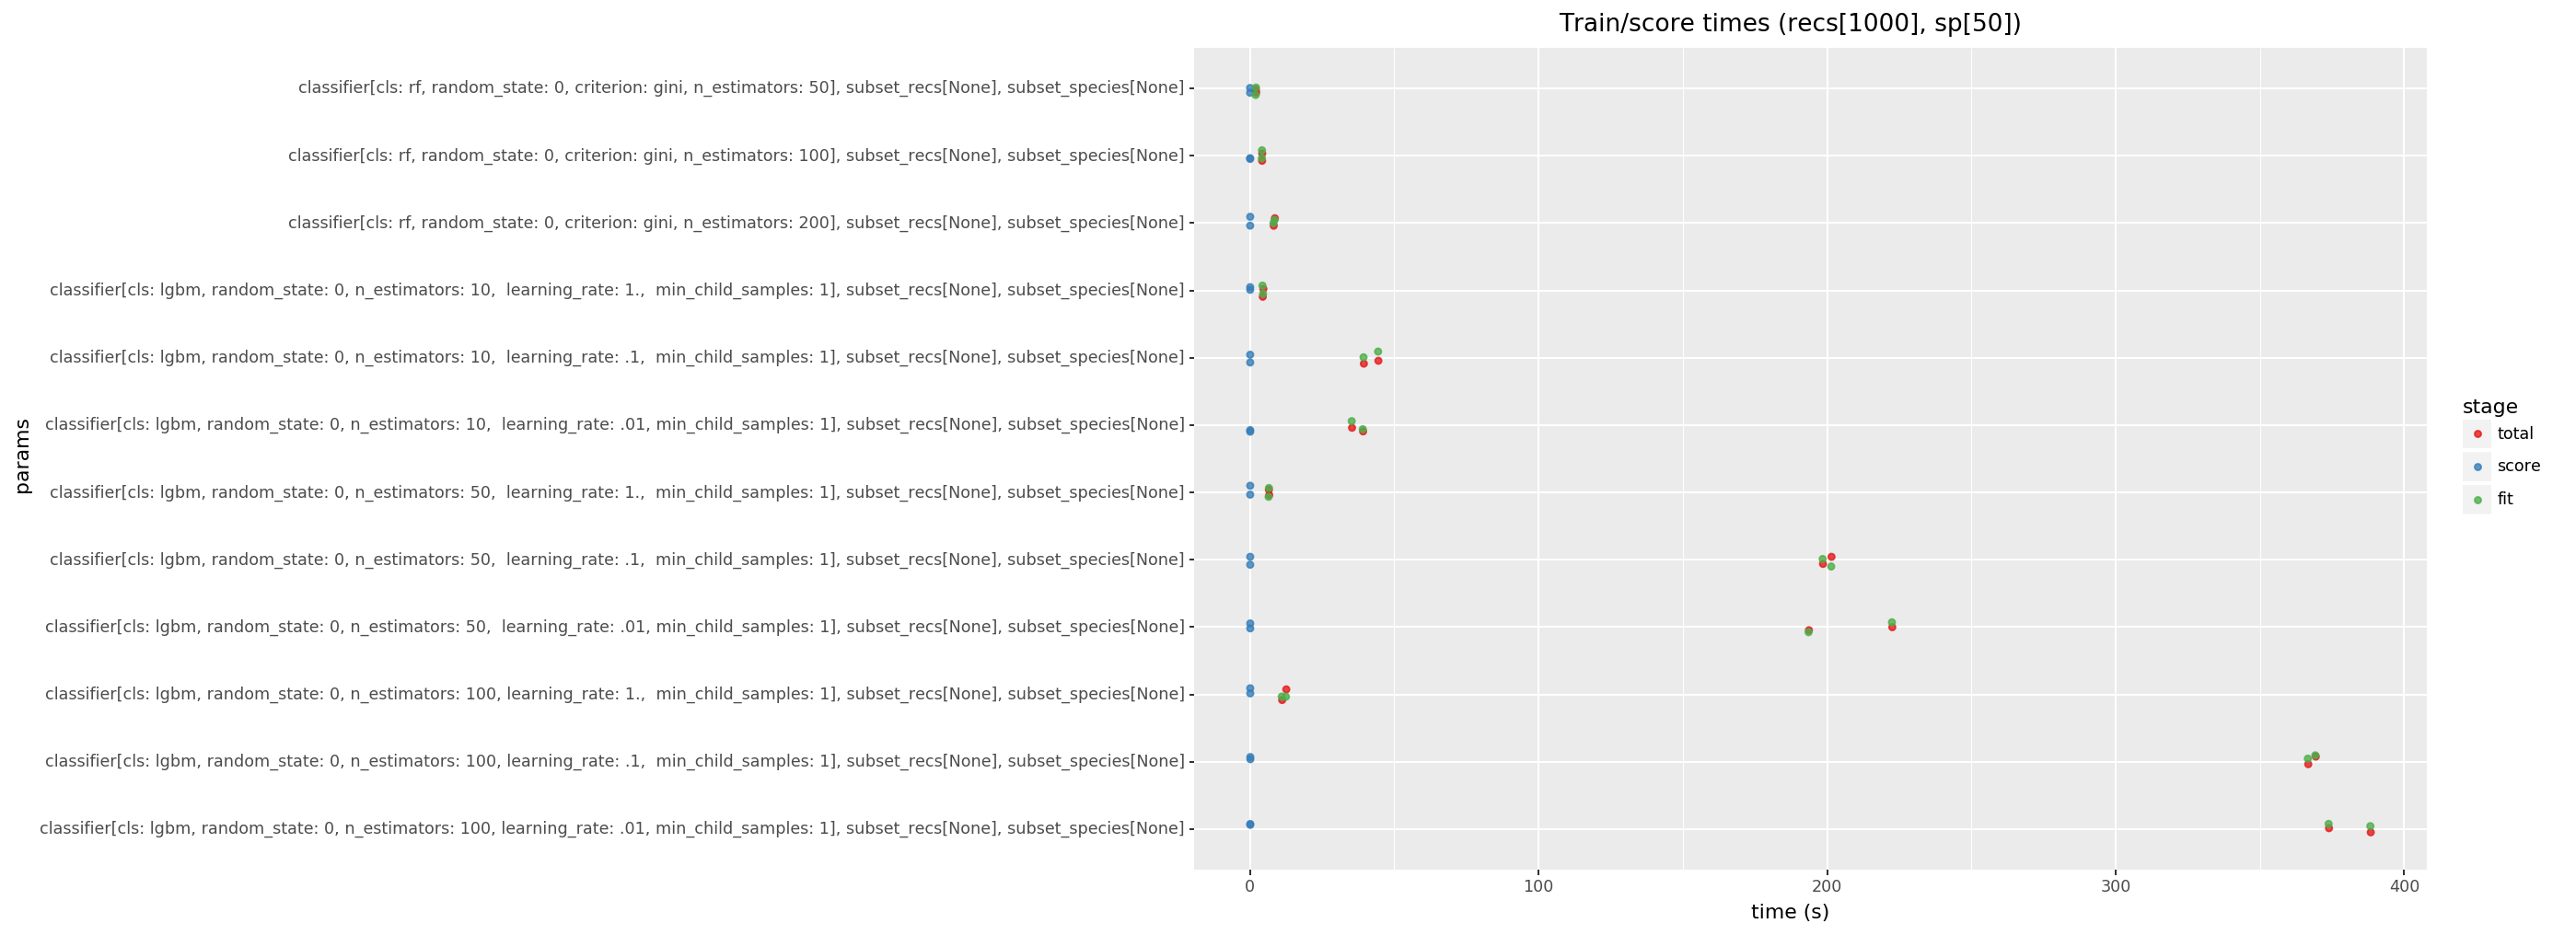

<ggplot: (-9223372036537268571)>

In [ ]:
(cv_models
    .assign(total_time=lambda df: df.fit_time + df.score_time)
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['fit_time', 'score_time', 'total_time'],
        var_name='stage',
        value_name='time',
    ))
    .assign(
        stage=lambda df: df.stage.str.replace('_time', ''),
        group=lambda df: df.classifier_type.str.cat(df.stage, '/'),
    )
    .pipe(df_ordered_cat,
        params=lambda df: reversed(param_list),
        stage=lambda df: reversed(sorted(df.stage.unique())),  # Make stage=total (last by alpha) be red (first color)
    )
    .pipe(ggplot, aes(x='params', y='time', color='stage'))
    + geom_jitter(alpha=.8, width=.1, height=1e-9, random_state=0)
    + coord_flip()
    + expand_limits(y=0)
    + scale_color_cmap_d(mpl.cm.Set1)
    + ylab('time (s)')
    + ggtitle(f'Train/score times ({recs_stats})')
)

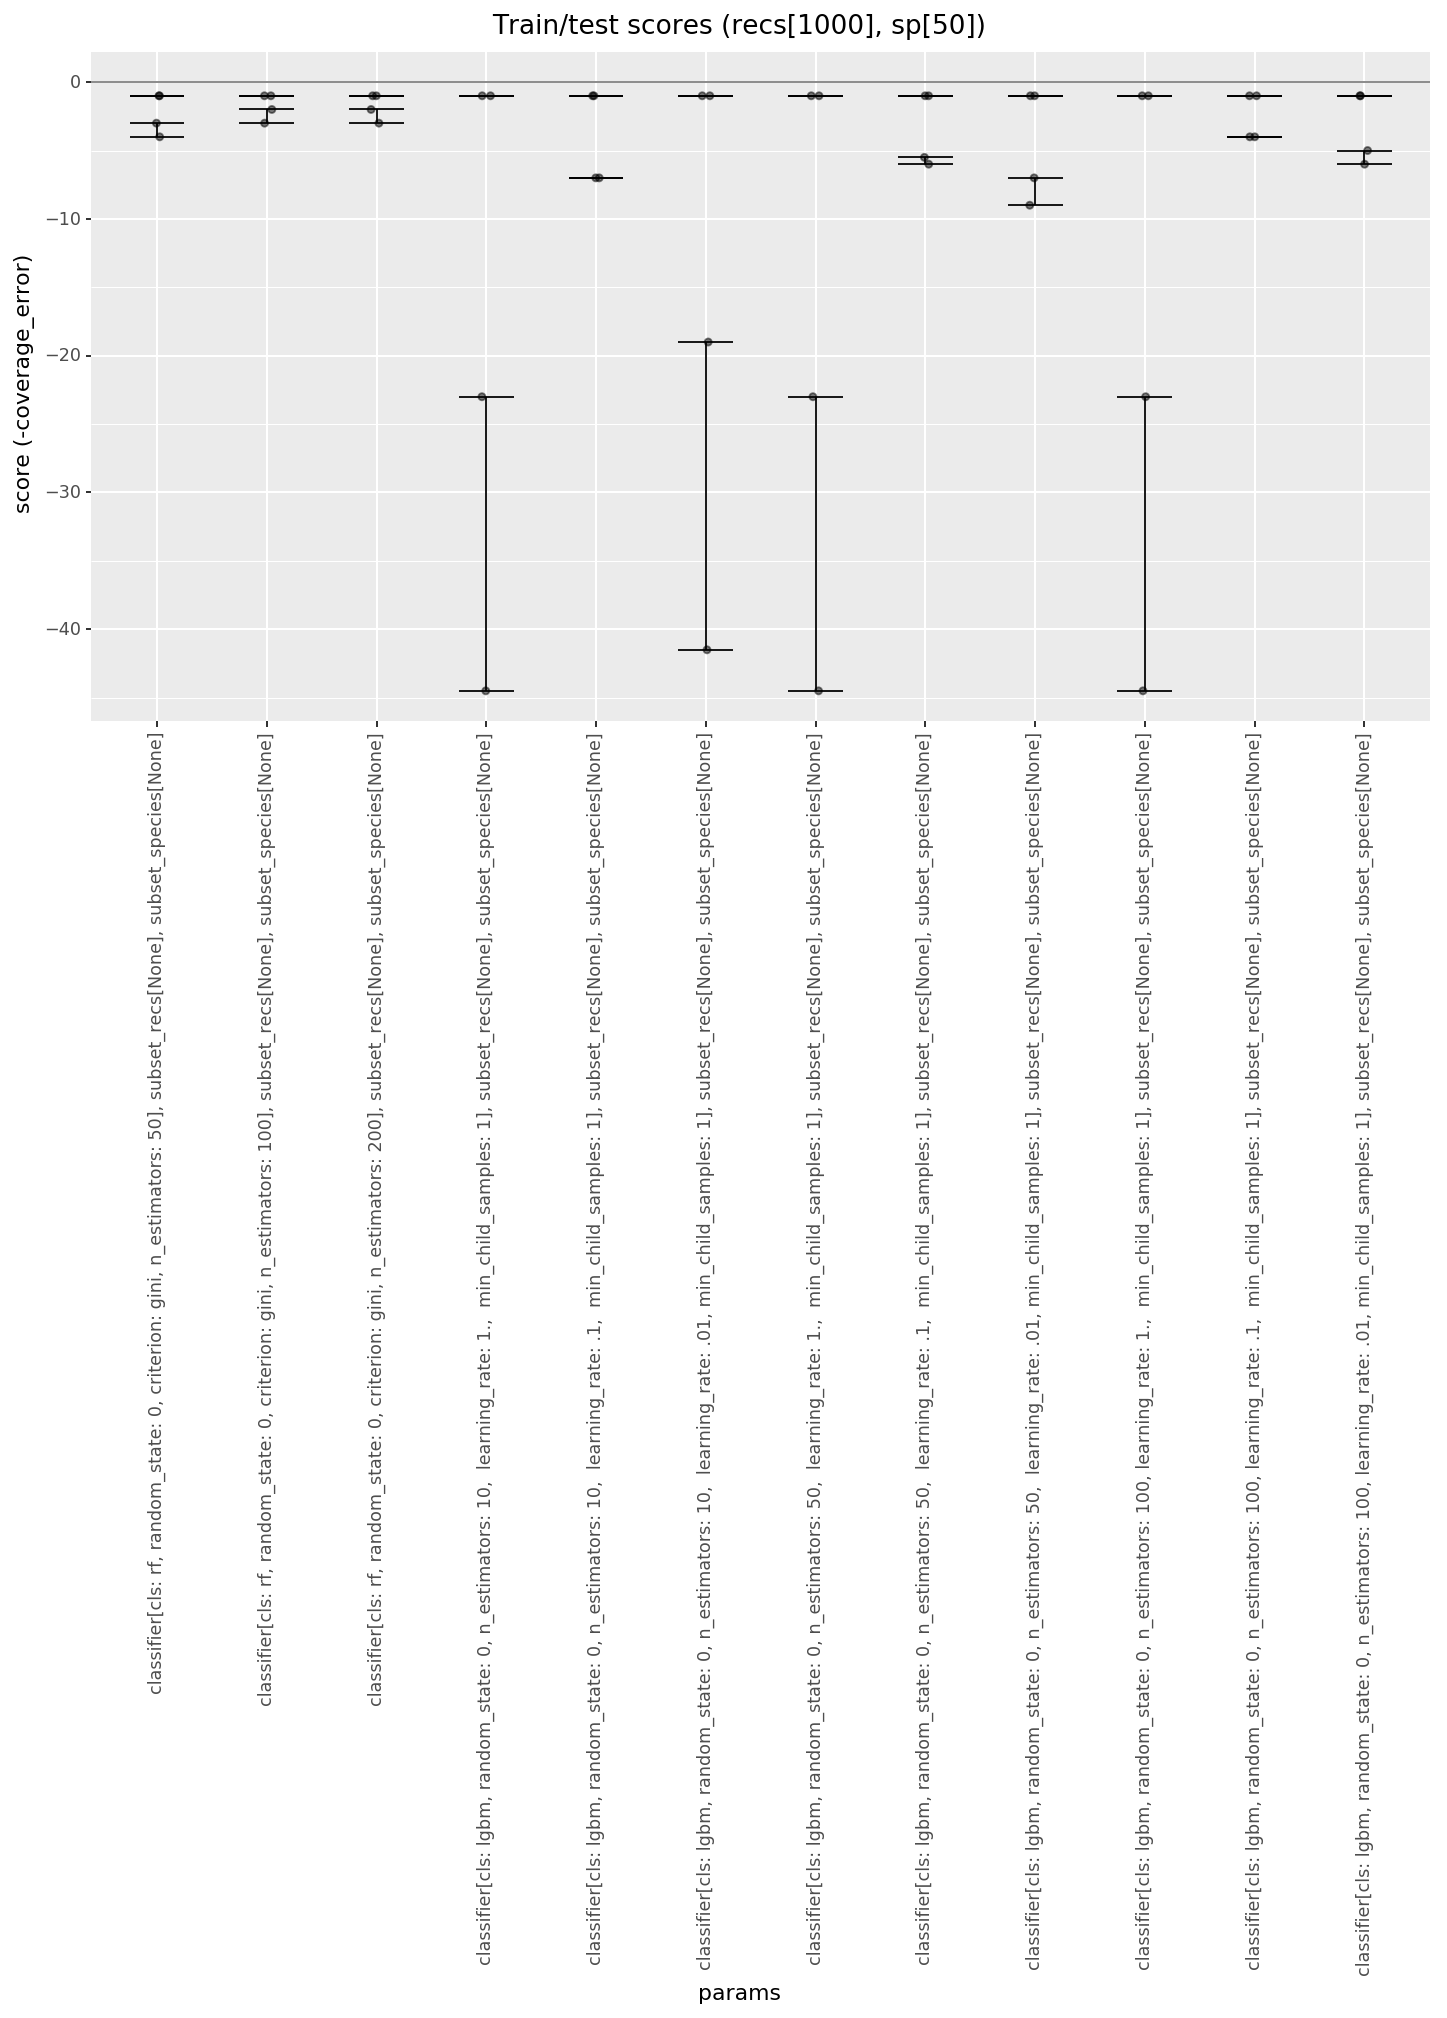

<ggplot: (304138125)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.classifier_type.str.cat(df.split, '/'),
    )
    .pipe(df_ordered_cat,
        params=lambda df: param_list,
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(ggplot, aes(
        x='params',
        y='score',
        # color='group',  # Ran out of colors
    ))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05, height=1e-9)
    # + geom_point(alpha=.5)
    # + geom_line(aes(group='str(group) + str(fold)'), alpha=.2)  # More trouble than it's worth
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    # + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)  # More trouble than it's worth
    # + scale_color_cmap_d(mpl.cm.tab10)
    # + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    # + coord_cartesian(ylim=(-35, 0))
    + ylab('score (-coverage_error)')
    + ggtitle(f'Train/test scores ({recs_stats})')
)

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(param_list))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/12]
  fold[*/2]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            classifier_type=row.classifier_type,
            subsets=row.subsets,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
)
display(
    df_summary(coverage_errors_all_all).T,
    coverage_errors_all_all[:10],
)

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

  8%|██████▉                                                                            | 2/24 [00:00<00:01, 14.01it/s]

 17%|█████████████▊                                                                     | 4/24 [00:00<00:01, 13.77it/s]

 25%|████████████████████▊                                                              | 6/24 [00:00<00:01, 13.92it/s]

 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:01, 14.07it/s]

 42%|██████████████████████████████████▏                                               | 10/24 [00:00<00:00, 14.06it/s]

 50%|█████████████████████████████████████████                                         | 12/24 [00:00<00:00, 14.15it/s]

 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:00<00:00, 14.17it/s]

 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:01<00:00, 14.17it/s]

 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:01<00:00, 14.10it/s]

 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:01<00:00, 14.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:01<00:00, 14.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 14.12it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,1495200,4800,4800,24,NaN,NaN,"classifier[cls: lgbm, random_state: 0, n_estimators: 10, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 10, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: lgbm, random_state: 0, n_estimators: 50, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 50], subset_recs[None], subset_species[None], fold[1]"
params,object,2365600,4800,4800,12,NaN,NaN,"classifier[cls: lgbm, random_state: 0, n_estimators: 10, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 10, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 50, learning_rate: 1., min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 50], subset_recs[None], subset_species[None]"
classifier_type,object,1175600,4800,4800,12,NaN,NaN,"classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 10, 'learning_rate': 0.01, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 10, 'learning_rate': 1.0, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 1.0, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 50, 'learning_rate': 1.0, 'min_child_samples': 1}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 50}]"
subsets,object,582400,4800,4800,1,NaN,NaN,"subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]"
fold,int64,124800,4800,4800,2,NaN,NaN,0,0,0,1,1
i,int64,134352,4800,4800,364,NaN,NaN,0,244,497,754,995
y_true,object,408000,4800,4800,50,NaN,NaN,AMDI,CASP,LEBI,RCKI,YBCH
coverage_error,float64,115200,4800,4800,50,NaN,NaN,1,2,7,40,50


,model_id,params,classifier_type,subsets,fold,i,y_true,coverage_error
0,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,118,LBCU,19.0
1,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,42,GREG,48.0
2,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,43,GREG,5.0
3,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,754,NAWA,50.0
4,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,209,CATE,49.0
5,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,887,SCOR,4.0
6,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,909,BRBL,2.0
7,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,563,BTGN,9.0
8,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","class

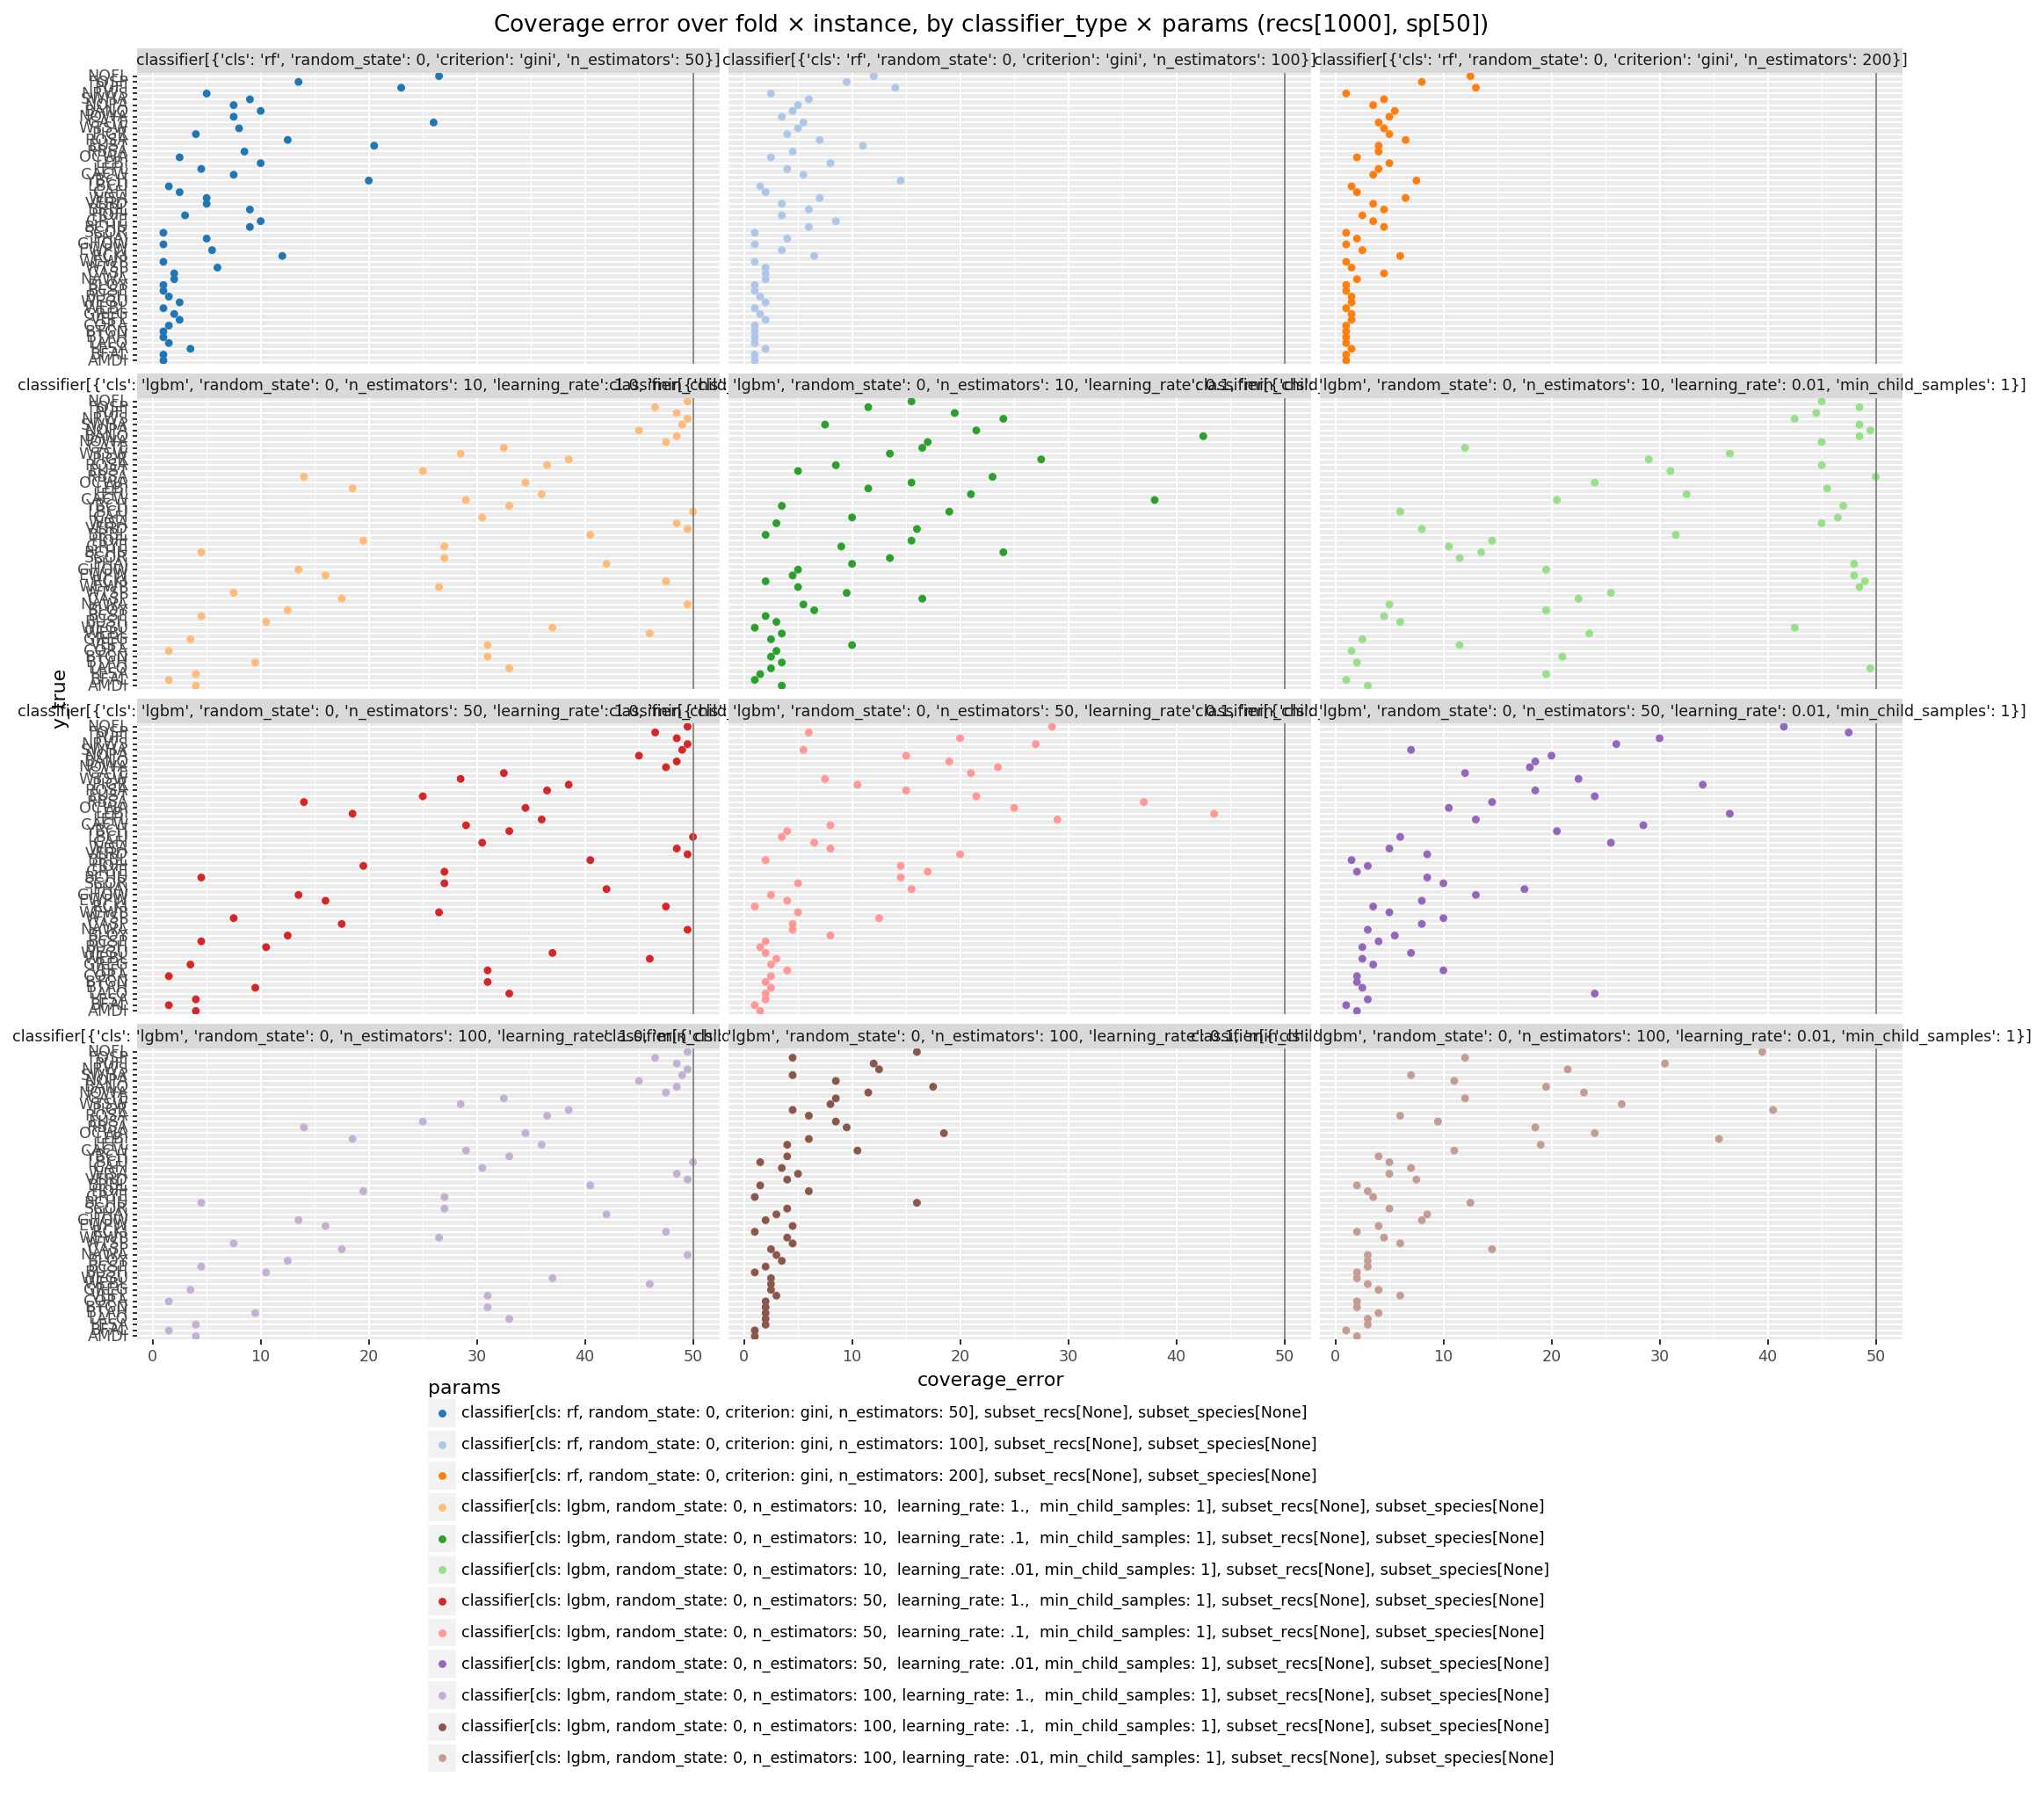

<ggplot: (-9223372036545031364)>

In [ ]:
# Facet by classifier_type, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
        params=lambda df: reversed(df.params.unique()),
        classifier_type=lambda df: reversed(df.classifier_type.unique()),
    )
    .pipe(ggplot, aes(x='y_true', y='coverage_error', color='params'))
    + facet_wrap('classifier_type', ncol=3)
    # + facet_grid('subsets ~ classifier_type')
    # + geom_line(aes(group='params'), stat='summary', fun_y=np.median)  # TODO Bad interpolation with subset_species
    + geom_point(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip(
        # ylim=(0, min(30, len(np.unique(y)))),  # Restore eventually
    )
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(legend_position='bottom', legend_direction='vertical')
    + theme_figsize(width=12*1.5, aspect_ratio=1/2)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by classifier_type $\times$ params ({recs_stats})')
)

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_list))
    .pipe(ggplot, aes(x='params', y='coverage_error', color='classifier_type'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params ({recs_stats})')
)

[skip]

# Model diagnostics: one model, all folds

In [ ]:
params_i = -1
params = param_list[params_i]
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), params))
print('  fold[*/%s]' % cv.cv.n_splits)

param_list:
  0: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 50], subset_recs[None], subset_species[None]'
  1: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 100], subset_recs[None], subset_species[None]'
  2: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 200], subset_recs[None], subset_species[None]'
  3: 'classifier[cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: 1.,  min_child_samples: 1], subset_recs[None], subset_species[None]'
  4: 'classifier[cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .1,  min_child_samples: 1], subset_recs[None], subset_species[None]'
  5: 'classifier[cls: lgbm, random_state: 0, n_estimators: 10,  learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]'
  6: 'classifier[cls: lgbm, random_state: 0, n_estimators: 50,  learning_rate: 1.,  min_child_samples: 1], subset_recs[None], subset_species[None]'
  7: 'classifier[cls: lgbm, random

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,79200,400,400,2,NaN,NaN,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[1]"
params,object,188400,400,400,1,NaN,NaN,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]"
classifier_type,object,157200,400,400,1,NaN,NaN,"classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]"
subsets,object,67200,400,400,1,NaN,NaN,"subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]","subset_recs[None], subset_species[None]"
fold,int64,10400,400,400,2,NaN,NaN,0,0,0,1,1
i,int64,11196,400,400,364,NaN,NaN,0,244,497,754,995
y_true,object,35020,400,400,50,NaN,NaN,AMDI,CASP,LEBI,RCKI,YBCH
coverage_error,float64,9600,400,400,49,NaN,NaN,1,2,5,35,50


,model_id,params,classifier_type,subsets,fold,i,y_true,coverage_error
0,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,118,LBCU,19.0
1,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,42,GREG,48.0
2,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,43,GREG,5.0
3,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,754,NAWA,50.0
4,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,209,CATE,49.0
5,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,887,SCOR,4.0
6,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,909,BRBL,2.0
7,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None]","classifier[{'cls': 'lgbm', 'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.01, 'min_child_samples': 1}]","subset_recs[None], subset_species[None]",0,563,BTGN,9.0
8,"classifier[cls: lgbm, random_state: 0, n_estimators: 100, learning_rate: .01, min_child_samples: 1], subset_recs[None], subset_species[None], fold[0]","class

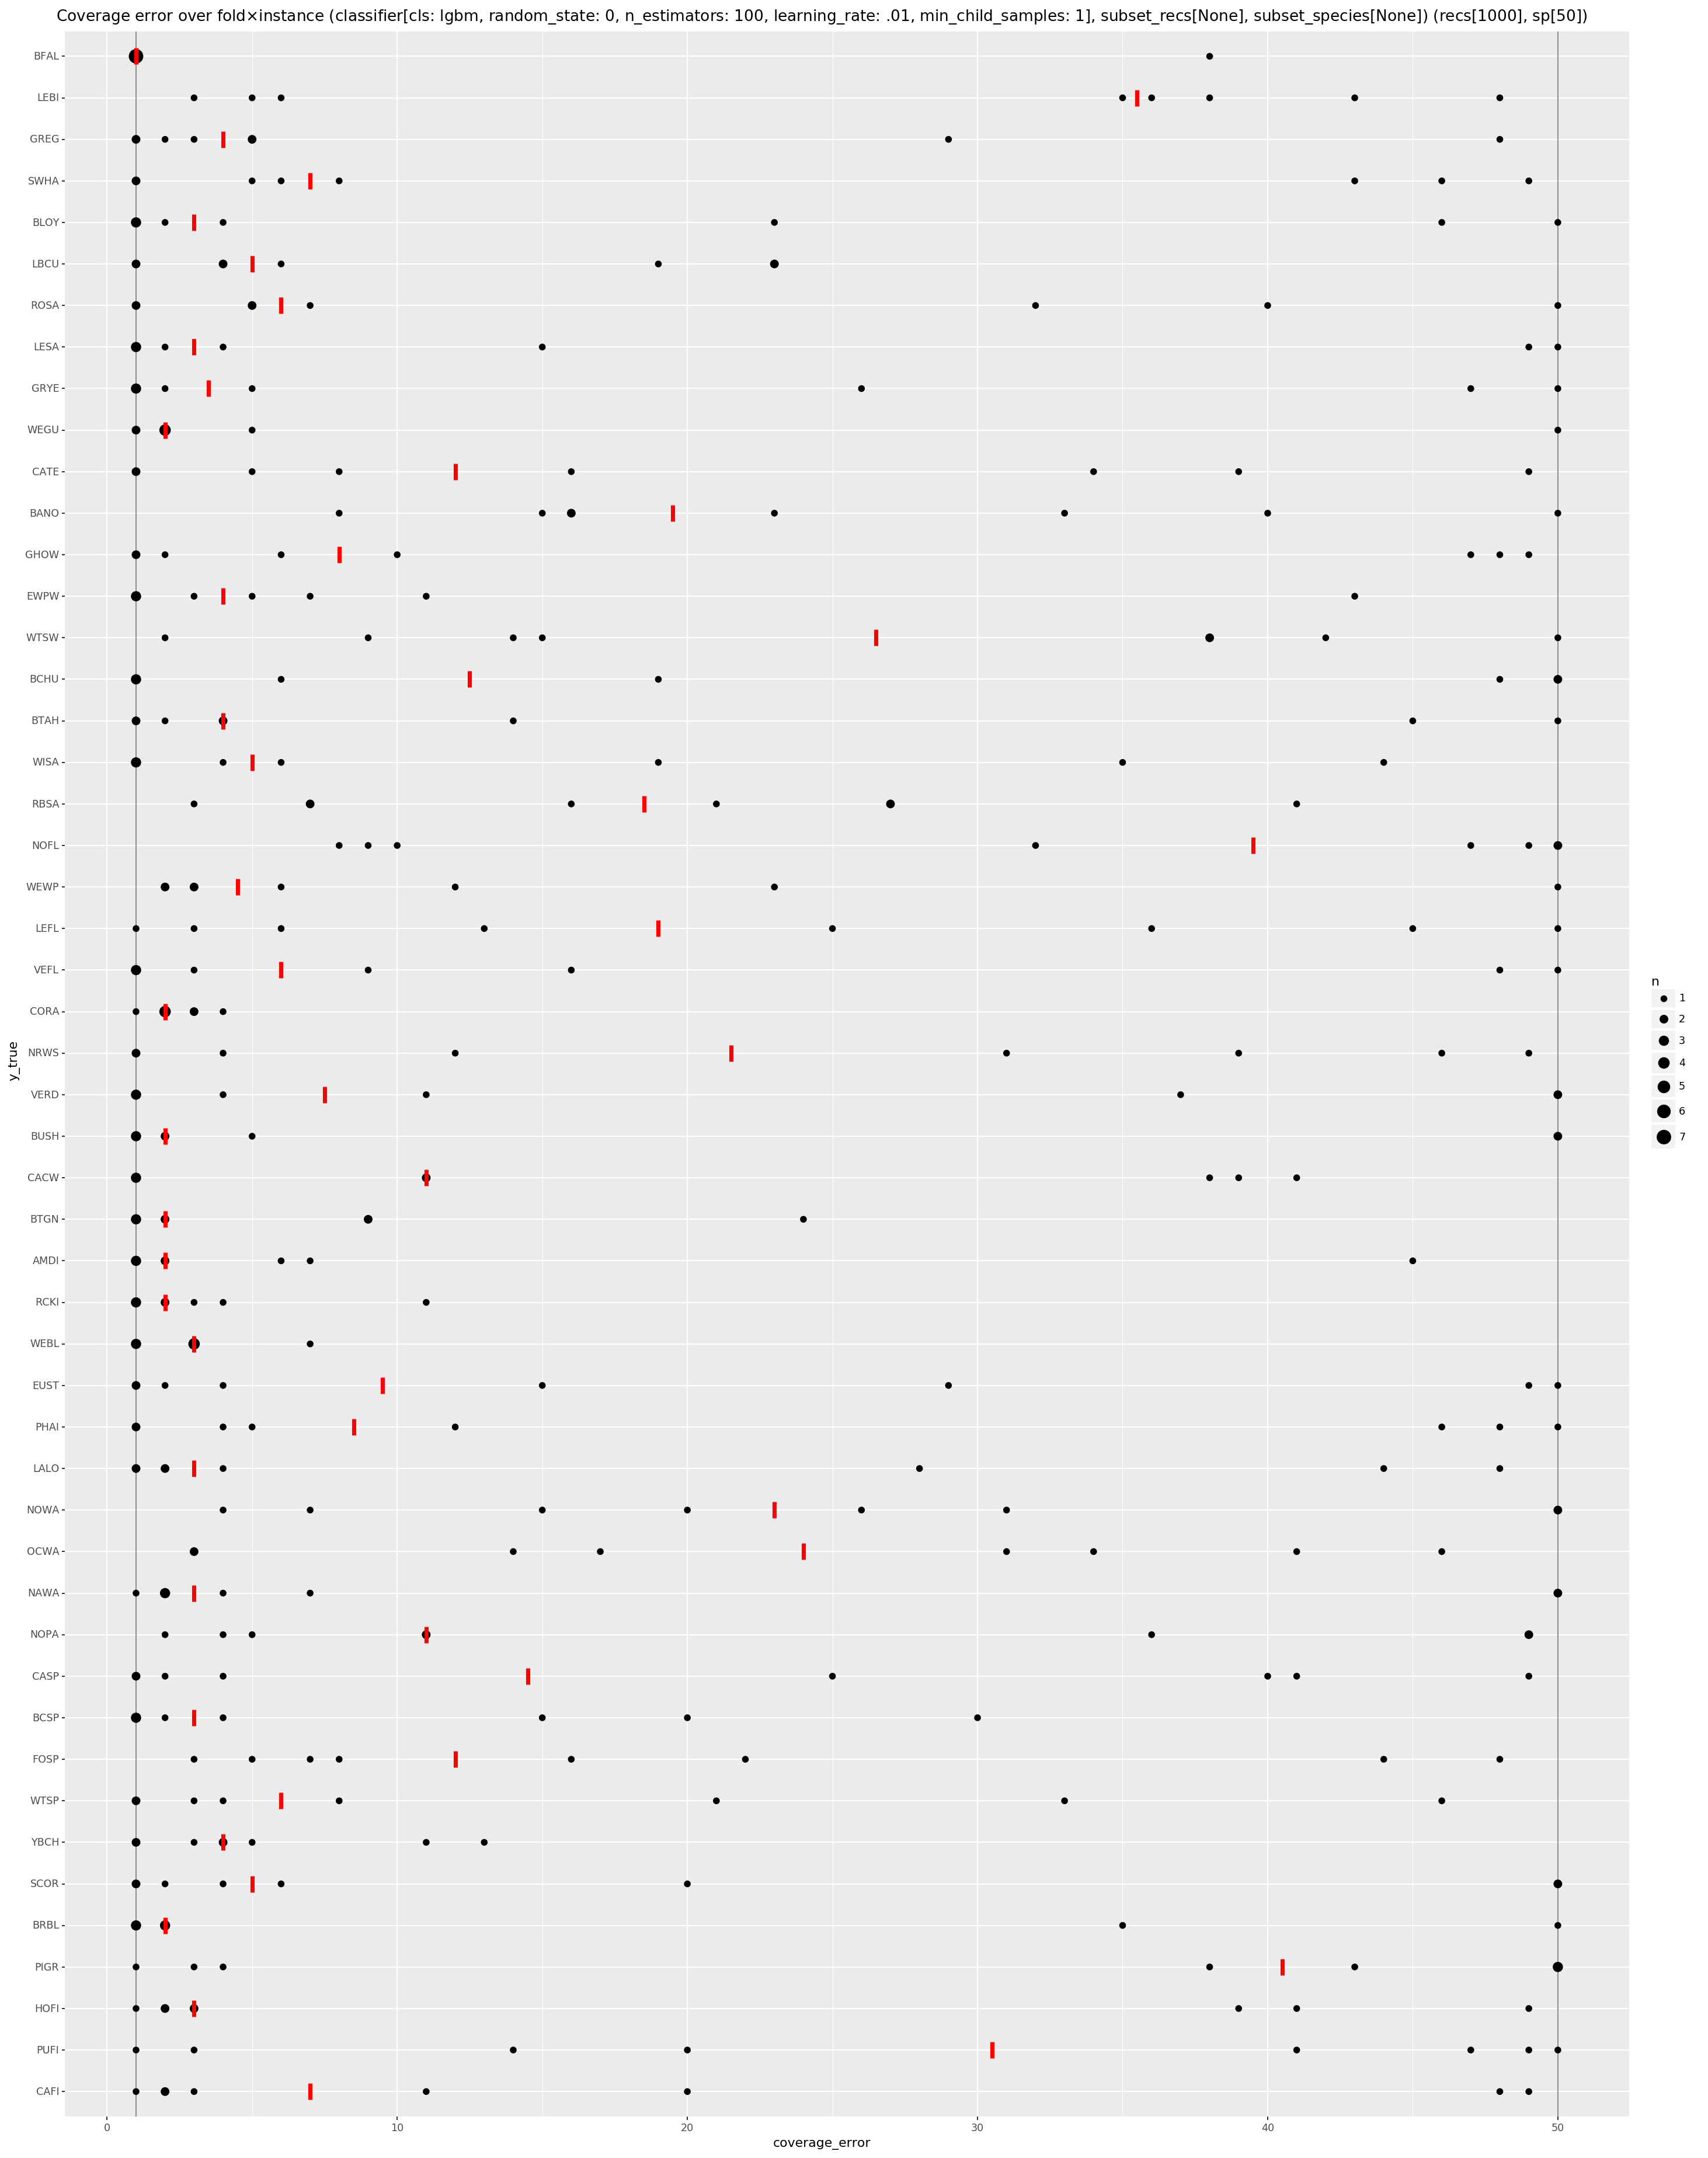

<ggplot: (-9223372036543129621)>

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance ({params}) ({recs_stats})')
)

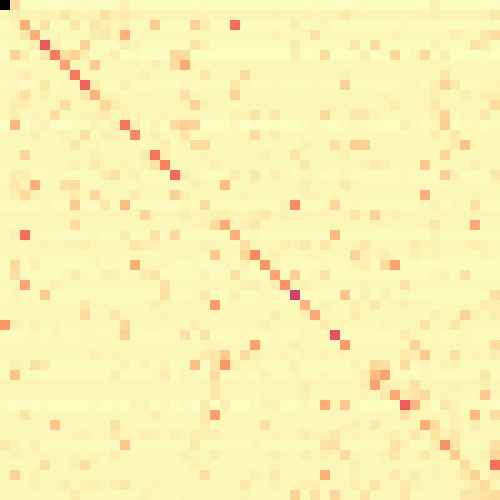

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
            title=f'({recs_stats})',
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = param_list[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id}) ({recs_stats})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
        title=f'({recs_stats})',
    )

[skip]